In [7]:
import numpy as np
import pylab
import networkx as nx

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
import pickle

import random
random.seed(1234)

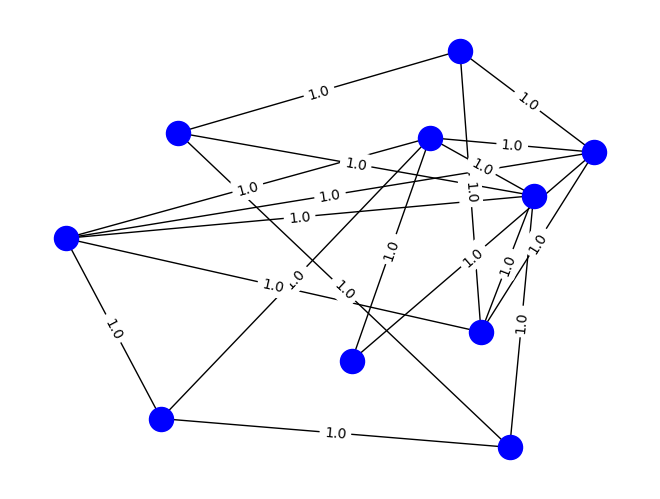

In [8]:
from MaxCut import MaxCut
with open('max_cut_10.pkl', 'rb') as file:
    max_cut = pickle.load(file)
max_cut.plot_graph()

In [9]:
qubit_op = max_cut.get_operator()

In [10]:
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    # algorithm_globals.random_seed = 50
    # ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = QAOA(optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')), reps=2)
    result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimizer: COBYLA        

AttributeError: 'tuple' object has no attribute 'num_qubits'

In [28]:
pylab.rcParams['figure.figsize'] = (6, 6)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

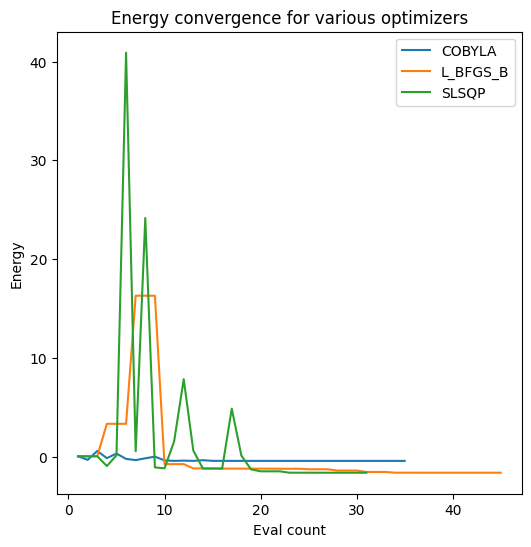

In [29]:
import matplotlib.pyplot as plt
plt.show()

In [31]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -13.50000


In [35]:
pylab.rcParams['figure.figsize'] = (6, 6)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');

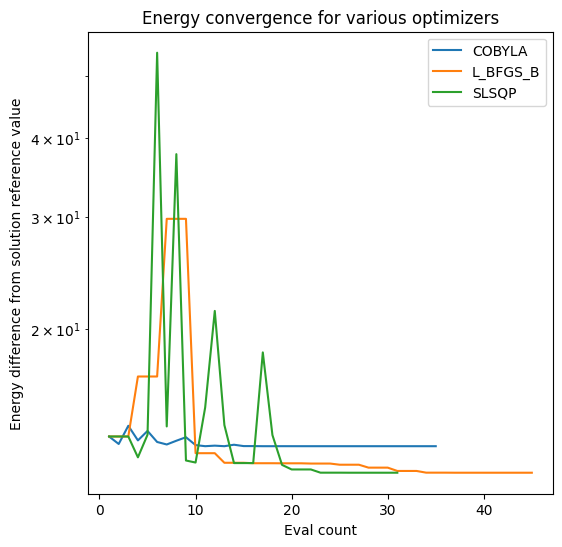

In [36]:
plt.show()

In [37]:
from qiskit.opflow.gradients import Gradient

algorithm_globals.random_seed = 50
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

optimizer = SLSQP(maxiter=60)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

vqe = QAOA(optimizer, callback=store_intermediate_result,
          gradient=Gradient(grad_method='fin_diff'),
          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
print(f'Value using Gradient: {result.eigenvalue.real:.5f}')

KeyboardInterrupt: 

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence using Gradient')
pylab.legend(loc='upper right');
plt.show()